In [2]:
import numpy as np
from utils import *
from mpc_function import *

# 1.  Check the functionality of:
## 1.1. transform_tensor_to_finite & transform_finite_to_tensor

dimensions=[4, 2, 4, 2], total_dimension=12


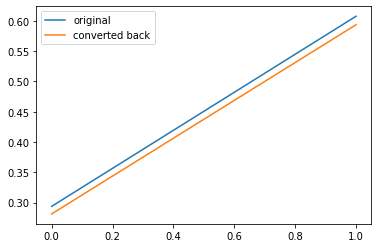

In [35]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import copy

from utils import model_dimension

class MLP(nn.Module):
    def __init__(self, dim_in, dim_hidden, dim_out):
        super(MLP, self).__init__()
        self.layer_input = nn.Linear(dim_in, dim_hidden)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()
        self.layer_hidden = nn.Linear(dim_hidden, dim_out)

    def forward(self, x):
        x = x.view(-1, x.shape[1]*x.shape[-2]*x.shape[-1])
        x = self.layer_input(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_hidden(x)
        return x

prime_number = 2 ** 30 - 35
q_bit = 5

NN = MLP(2,2,2)

dimensions, total_dimension = model_dimension(NN.state_dict())
print(f"dimensions={dimensions}, total_dimension={total_dimension}")

tmp_weights = NN.state_dict()

tmp_tensor_ff = transform_tensor_to_finite(copy.deepcopy(tmp_weights), p=prime_number, q_bits=q_bit)

tmp_tensor_real = transform_finite_to_tensor(copy.deepcopy(tmp_tensor_ff), p=prime_number, q_bits=q_bit)


plt.plot(tmp_weights['layer_input.weight'][0],label='original')
plt.plot(tmp_tensor_real['layer_input.weight'][0], label='converted back')
plt.legend()




## 1.2. Encoding / Masking / Decoding

### 1.2.1 Generate models

In [67]:
%load_ext autoreload
%autoreload 2

from utils import model_dimension
from mpc_function import aggregate_models_in_finite

N = 4
U = 2
T = 0
p = prime_number

d = total_dimension

w_locals_FF = []
for i in range(N):
    NN = MLP(2,2,2)

    tmp_weights = NN.state_dict()

    tmp_tensor_ff = transform_tensor_to_finite(copy.deepcopy(tmp_weights), p=prime_number, q_bits=q_bit)

    w_locals_FF.append(copy.deepcopy(tmp_tensor_ff))

w_sum = aggregate_models_in_finite(w_locals_FF, p)

print(w_sum)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
OrderedDict([('layer_input.weight', array([[1073741784, 1073741744],
       [1073741750, 1073741783]], dtype=int64)), ('layer_input.bias', array([1073741764,          0], dtype=int64)), ('layer_hidden.weight', array([[1073741769, 1073741755],
       [        10,          1]], dtype=int64)), ('layer_hidden.bias', array([1073741778, 1073741761], dtype=int64))])


### 1.2.2. Offline - Encoding the masks

In [104]:
d_encoded = d // (U-T)

local_mask_buffer   = np.zeros((N, d)).astype('int64')

encoded_mask_buffer = np.zeros((N, N, d_encoded)).astype('int64')

for i in range(N):
    tmp = np.random.randint(p, size=(2)).astype('int64')
    tmp1 = tmp[0] * np.ones((d_encoded,1)).astype('int64')
    tmp2 = tmp[1] * np.ones((d_encoded,1)).astype('int64')
    local_mask = np.concatenate([tmp1, tmp2], axis=0)
    # local_mask = np.mod(local_mask,p)
    # local_mask = np.random.randint(p, size=(d, 1)).astype('int64')
    
    local_mask_buffer[i,:] = local_mask[:,0]


    encoded_mask_set = mask_encoding(d, N, U, T, p, local_mask)

    for j in range(N):
        encoded_mask_buffer[j,i,:] = encoded_mask_set[j,:]

    # print(np.shape(local_mask), np.shape(encoded_mask_set))

@mask_encoding, LCC_in=[[680331467 680331467 680331467 680331467 680331467 680331467]
 [ 80426342  80426342  80426342  80426342  80426342  80426342]]
@mask_encoding, encoded_mask_set=[[ 110863522  110863522  110863522  110863522  110863522  110863522]
 [ 584700186  584700186  584700186  584700186  584700186  584700186]
 [1058536850 1058536850 1058536850 1058536850 1058536850 1058536850]
 [ 458631725  458631725  458631725  458631725  458631725  458631725]]
@mask_encoding, LCC_in=[[620178032 620178032 620178032 620178032 620178032 620178032]
 [641176901 641176901 641176901 641176901 641176901 641176901]]
@mask_encoding, encoded_mask_set=[[452187080 452187080 452187080 452187080 452187080 452187080]
 [473185949 473185949 473185949 473185949 473185949 473185949]
 [494184818 494184818 494184818 494184818 494184818 494184818]
 [515183687 515183687 515183687 515183687 515183687 515183687]]
@mask_encoding, LCC_in=[[85398354 85398354 85398354 85398354 85398354 85398354]
 [84264901 84264901 8426

### 1.2.3. Masking the local model

In [106]:
from mpc_function import model_masking

U = 2
U_set = np.array([0,1])

maked_models = []
local_masks_sum     = np.zeros((d,)).astype('int64')

for i in U_set:
    maked_model = model_masking(w_locals_FF[i], dimensions, np.reshape(local_mask_buffer[i], (d,1)), p)
    maked_models.append(maked_model)   

    local_masks_sum = np.mod(local_masks_sum + local_mask_buffer[i], p)     

masked_model_sum = aggregate_models_in_finite(maked_models, p)


print((local_masks_sum))
print(p)
# print(encoded_mask_buffer)

[226767710 226767710 226767710 226767710 226767710 226767710 721603243
 721603243 721603243 721603243 721603243 721603243]
1073741789


### 1.2.4. Reconstructing the aggregate of masks

In [108]:
aggregate_encoded_masks = np.zeros((N,d_encoded),dtype='int64')

# for i in range(N):    
aggregate_encoded_masks = np.sum(encoded_mask_buffer[:,U_set,:], axis=1)
aggregate_encoded_masks = np.mod(aggregate_encoded_masks, p)


alpha_s = np.array(range(N)) + 2
beta_s = np.array(range(U)) + 10

eval_points = alpha_s[U_set]
aggregate_mask = LCC_decoding_with_points(aggregate_encoded_masks[U_set], eval_points, beta_s, p)
aggregate_mask = np.reshape(aggregate_mask, (U * (d // (U - T)), 1))
aggregate_mask = aggregate_mask[0:d]

print(np.shape(aggregate_mask))
print(aggregate_mask)

(12, 1)
[[226767710]
 [226767710]
 [226767710]
 [226767710]
 [226767710]
 [226767710]
 [721603243]
 [721603243]
 [721603243]
 [721603243]
 [721603243]
 [721603243]]
